In [246]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import string
import re
import nltk
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from keras.utils import pad_sequences
from sklearn.feature_selection import SelectKBest,chi2
from datetime import datetime
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from google.colab import files,drive
from wordcloud import WordCloud, STOPWORDS
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV,StratifiedKFold
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
print("Running Panda Version:"+pd.__version__)
print("Running TensorFlow Version:"+ tf.__version__)
print("Running Keras API Version:"+ keras.__version__)
print("Running Python {0}.{1}".format(sys.version_info[:2][0],sys.version_info[:2][1]))

Running Panda Version:2.2.2
Running TensorFlow Version:2.17.0
Running Keras API Version:3.4.1
Running Python 3.10


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [157]:
seed = 0
np.random.seed(seed)

In [158]:
#drive.mount('/content/drive')

In [159]:
uploaded = files.upload()

Saving Tweets.csv to Tweets (2).csv


# ***Dataset Summary, Analysis,Cleaning and Feature Engineering***

In [160]:
dataset = pd.read_csv("Tweets.csv",na_values=['NA'], low_memory=False)

### Dataset shapes

In [161]:
print('Dataset structure: rows =',dataset.shape[0], ' - columns =',dataset.shape[1])

Dataset structure: rows = 14640  - columns = 15


### Some random rows

In [162]:
dataset.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


###  Descriptive statistics for the dataset

In [163]:
print(dataset.columns.values)
print('-'*100)
dataset.describe()

['tweet_id' 'airline_sentiment' 'airline_sentiment_confidence'
 'negativereason' 'negativereason_confidence' 'airline'
 'airline_sentiment_gold' 'name' 'negativereason_gold' 'retweet_count'
 'text' 'tweet_coord' 'tweet_created' 'tweet_location' 'user_timezone']
----------------------------------------------------------------------------------------------------


,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [164]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [165]:
print('Dataset contains Duplicated rows? ',dataset.duplicated().any())
print('-'*100)
print('Train Dataset contains Missing values?\n',dataset.isnull().sum())

Dataset contains Duplicated rows?  True
----------------------------------------------------------------------------------------------------
Train Dataset contains Missing values?
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [166]:
dataset.airline_sentiment_confidence.value_counts()

,count
airline_sentiment_confidence,
1.0000,10445
0.6667,71
0.6632,35
0.6596,30
0.6559,30
...,...
0.3674,1
0.6155,1
0.3708,1


In [167]:
dataset.airline_sentiment.value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


In [168]:
print('Number of classes of sentiments: ',len(dataset.airline_sentiment.unique().tolist()))

Number of classes of sentiments:  3


In [169]:
print('Number of airlines: ',dataset.airline.unique().tolist())

Number of airlines:  ['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American']


In [170]:
print('Categories: ',dataset.airline_sentiment.unique().tolist())

Categories:  ['neutral', 'positive', 'negative']


In [171]:
print(dataset.tweet_created.min())

2015-02-16 23:36:05 -0800


In [172]:
print(dataset.tweet_created.max())

2015-02-24 11:53:37 -0800


## Data preprocessing and visualization.

In [173]:
def split_dataset(df:pd.DataFrame,test_percentage:float)-> tuple[pd.DataFrame,pd.DataFrame]:
  shuffle = np.random.permutation(len(df))
  test_size = int(len(df) * test_percentage)
  test_aux = shuffle[:test_size]
  train_aux = shuffle[test_size:]
  return (df.iloc[train_aux],df.iloc[test_aux])

In [174]:
train_set,test_set= split_dataset(dataset,0.2)

In [175]:
train_set,val_set= split_dataset(train_set,0.2)

In [176]:
print(train_set.shape,test_set.shape,val_set.shape)

(9370, 15) (2928, 15) (2342, 15)


In [177]:
train_set.duplicated().any()

True

In [178]:
train_set.drop_duplicates(inplace=True)

In [179]:
train_set.shape

(9354, 15)

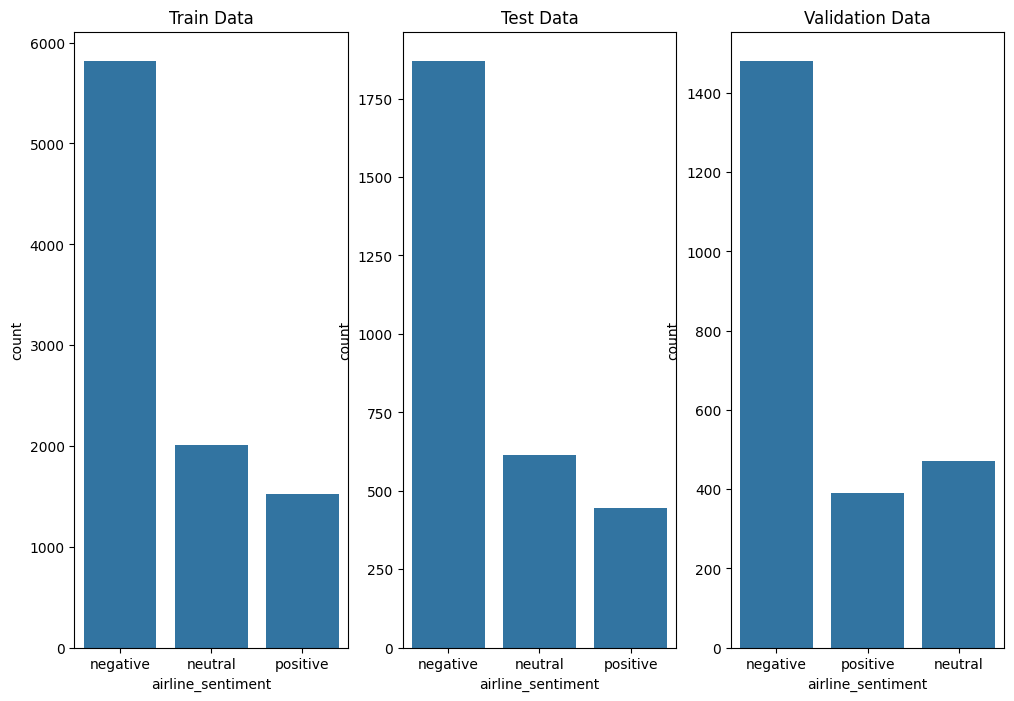

In [180]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
sns.countplot(x='airline_sentiment', data=train_set, ax=ax[0])
sns.countplot(x='airline_sentiment', data=test_set, ax=ax[1])
sns.countplot(x='airline_sentiment', data=val_set, ax=ax[2])
ax[0].set_title('Train Data')
ax[1].set_title('Test Data')
ax[2].set_title('Validation Data')
plt.show()
del ax,fig


### Removing user tags ( @user, links and emoticons )

In [181]:
def remove_url(tweet:str)->str:
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',tweet,re.IGNORECASE)
    result = ''.join([i for i in text if not i.isdigit()])
    return result

In [182]:
def remove_user_tags(tweet:str)->str:#For removing user tags(@user)
    user = re.compile(r'@\S+')
    text = user.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    return result

In [183]:
def clean_data(tweet:str)-> pd.Series:
    str_without_tags = remove_user_tags(tweet)
    str_without_links = remove_url(str_without_tags)
    return pd.Series([str_without_links])

In [184]:
train_set[['text']] = train_set.apply(lambda x: clean_data(x.text),axis=1)
test_set[['text']] = test_set.apply(lambda x: clean_data(x.text),axis=1)
val_set[['text']] = val_set.apply(lambda x: clean_data(x.text),axis=1)

<ipython-input-184-10a1d958c1dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['text']] = test_set.apply(lambda x: clean_data(x.text),axis=1)


In [185]:
train_set.sample(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7732,569300264349364224,positive,1.000,NaN,NaN,Delta,NaN,spaceracedjs,NaN,0,he just went above and beyond to be helpful,NaN,2015-02-21 16:58:54 -0800,Brooklyn,Eastern Time (US & Canada)
2371,569242047917502464,positive,0.358,NaN,0.0,United,NaN,ThatsVy,NaN,0,"Hi there, looks like my connection is delayed...",NaN,2015-02-21 13:07:34 -0800,SoCal,Pacific Time (US & Canada)
12871,569995335893848064,neutral,0.639,NaN,NaN,American,NaN,scottfmurphy,NaN,0,boom.,NaN,2015-02-23 15:00:52 -0800,"New York, NY",Central Time (US & Canada)


In [186]:
positive_sentiment = train_set[train_set.airline_sentiment == "positive"]
positive_text=positive_sentiment['text']
print('The Train Dataset contains :',positive_sentiment.shape[0],' positive tweets')
negative_sentiment = train_set[train_set.airline_sentiment == 'negative']
negative_text=negative_sentiment['text']
print('The Train Dataset contains :',negative_sentiment.shape[0],' negative tweets')
neutral_sentiment = train_set[train_set.airline_sentiment == 'neutral']
neutral_text=neutral_sentiment['text']
print('The Train Dataset contains :',neutral_sentiment.shape[0],' neutral tweets')

The Train Dataset contains : 1526  positive tweets
The Train Dataset contains : 5819  negative tweets
The Train Dataset contains : 2009  neutral tweets


In [187]:
#print(train_set.airline_sentiment.value_counts())

<ipython-input-188-d78d0fc988bc>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=train_set.airline.unique().tolist())


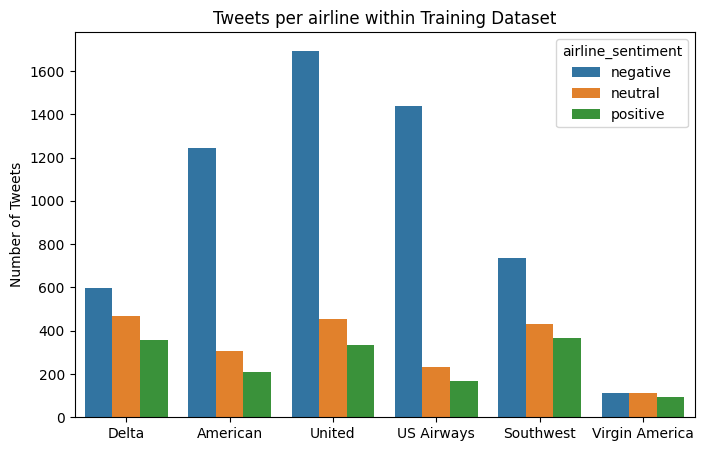

In [188]:
f, axes = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="airline", hue="airline_sentiment", data=train_set)
ax.set(xticklabels=train_set.airline.unique().tolist())
ax.set_xlabel('')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets per airline within Training Dataset')
del ax,f,axes

In [189]:
#For removing emoticons and creating flags for both sad and happy emoticons
def happy_emoticons_removal(tweet:str) ->tuple[str,int]:
    happy = re.compile(r"([xX;:]-?[dDpP)])")
    initial = len(tweet)
    text = happy.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

def sad_emoticons_removal(tweet:str) ->tuple[str,int]:
    happy = re.compile(r"([:]'?[/\|(])")
    initial = len(tweet)
    text = happy.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

In [190]:
def emoticon_removal(tweet:str)-> pd.Series:
    (str_without_happy_emoji,happy_emoji_flag) = happy_emoticons_removal(tweet)
    (str_without_emoji,sad_emoji_flag) = sad_emoticons_removal(str_without_happy_emoji)
    return pd.Series([str_without_emoji,happy_emoji_flag,sad_emoji_flag])

In [191]:
train_set[['text','happy_emoji_flag','sad_emoji_flag']] = train_set.apply(lambda x: emoticon_removal(x.text),axis=1)
test_set[['text','happy_emoji_flag','sad_emoji_flag']] = test_set.apply(lambda x: emoticon_removal(x.text),axis=1)
val_set[['text','happy_emoji_flag','sad_emoji_flag']] = val_set.apply(lambda x: emoticon_removal(x.text),axis=1)

<ipython-input-191-f85e234e7c20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['text','happy_emoji_flag','sad_emoji_flag']] = test_set.apply(lambda x: emoticon_removal(x.text),axis=1)
<ipython-input-191-f85e234e7c20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['text','happy_emoji_flag','sad_emoji_flag']] = test_set.apply(lambda x: emoticon_removal(x.text),axis=1)
<ipython-input-191-f85e234e7c20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [192]:
train_set.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,happy_emoji_flag,sad_emoji_flag
8183,568631243228762112,negative,1.0000,Bad Flight,0.6667,Delta,NaN,justchristina,NaN,0,# stewardesses can't work w/o a galley light!...,NaN,2015-02-19 20:40:27 -0800,"Boston, MA",Eastern Time (US & Canada),0,0
6870,570076673162543104,neutral,0.6608,NaN,NaN,Delta,NaN,mOnKofficial,NaN,0,“ We hope you're still our bae! man,NaN,2015-02-23 20:24:05 -0800,Philadelphia/Cali,Eastern Time (US & Canada),0,0
14616,569591393540288512,negative,1.0000,Cancelled Flight,1.0000,American,NaN,TheJoshAbides,NaN,0,"Cancelled Flights my flight, doesn't send an ...",NaN,2015-02-22 12:15:45 -0800,New York City,Eastern Time (US & Canada),0,0


<ipython-input-193-f825a3dbbe0b>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['False','True'])
<ipython-input-193-f825a3dbbe0b>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['True'])


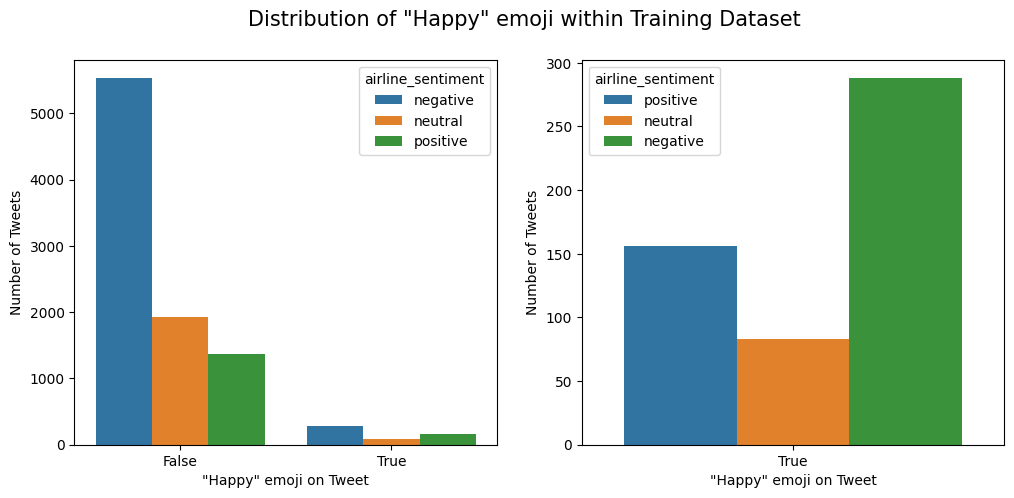

In [193]:
f, axes = plt.subplots(1,2,figsize=(12, 5))
ax = sns.countplot(x="happy_emoji_flag", hue="airline_sentiment", data=train_set,ax=axes[0])
ax.set(xticklabels=['False','True'])
ax.set_xlabel('"Happy" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
ax = sns.countplot(x="happy_emoji_flag", hue="airline_sentiment", data=train_set[train_set.happy_emoji_flag==1],ax=axes[1])
ax.set(xticklabels=['True'])
ax.set_xlabel('"Happy" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
f.suptitle('Distribution of "Happy" emoji within Training Dataset',fontsize=15)
del ax,f,axes

<ipython-input-194-8df11df7940e>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['False','True'])
<ipython-input-194-8df11df7940e>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['True'])


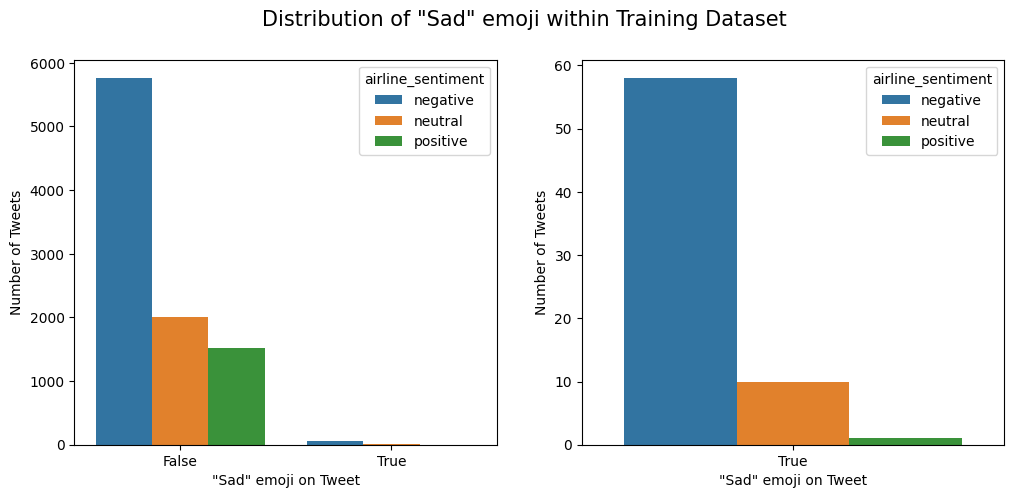

In [194]:
f, axes = plt.subplots(1,2,figsize=(12, 5))
ax = sns.countplot(x="sad_emoji_flag", hue="airline_sentiment", data=train_set,ax=axes[0])
ax.set(xticklabels=['False','True'])
ax.set_xlabel('"Sad" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
ax = sns.countplot(x="sad_emoji_flag", hue="airline_sentiment", data=train_set[train_set.sad_emoji_flag==1],ax=axes[1])
ax.set(xticklabels=['True'])
ax.set_xlabel('"Sad" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
f.suptitle('Distribution of "Sad" emoji within Training Dataset',fontsize=15)
del ax,f,axes

In [195]:
train_set.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,happy_emoji_flag,sad_emoji_flag
8183,568631243228762112,negative,1.0000,Bad Flight,0.6667,Delta,NaN,justchristina,NaN,0,# stewardesses can't work w/o a galley light!...,NaN,2015-02-19 20:40:27 -0800,"Boston, MA",Eastern Time (US & Canada),0,0
6870,570076673162543104,neutral,0.6608,NaN,NaN,Delta,NaN,mOnKofficial,NaN,0,“ We hope you're still our bae! man,NaN,2015-02-23 20:24:05 -0800,Philadelphia/Cali,Eastern Time (US & Canada),0,0


In [196]:
def stop_word_and_stemming(tweet:str):
    tknzr = TweetTokenizer(preserve_case=False,strip_handles=True, reduce_len=True)
    myStemmer = PorterStemmer()
    tweet = tknzr.tokenize(tweet)
    stop = stopwords.words('english')
    new_list = [myStemmer.stem(word) for word in tweet if word not in stop]
    tweet = ' '.join(new_list)
    return tweet

In [197]:
train_set['text'] = train_set['text'].apply(stop_word_and_stemming)
test_set['text'] = test_set['text'].apply(stop_word_and_stemming)
val_set['text'] = val_set['text'].apply(stop_word_and_stemming)

<ipython-input-197-30516ddc7618>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(stop_word_and_stemming)


In [198]:
#For removing punctuation
def remove_punctuations(text:str):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [199]:
train_set['text'] = train_set['text'].apply(remove_punctuations)
test_set['text'] = test_set['text'].apply(remove_punctuations)
val_set['text'] = val_set['text'].apply(remove_punctuations)

<ipython-input-199-07d13bfcbff7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(remove_punctuations)


In [200]:
train_set.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,happy_emoji_flag,sad_emoji_flag
8183,568631243228762112,negative,1.0000,Bad Flight,0.6667,Delta,NaN,justchristina,NaN,0,stewardess cant work w galley light back ny...,NaN,2015-02-19 20:40:27 -0800,"Boston, MA",Eastern Time (US & Canada),0,0
6870,570076673162543104,neutral,0.6608,NaN,NaN,Delta,NaN,mOnKofficial,NaN,0,“ hope still bae man,NaN,2015-02-23 20:24:05 -0800,Philadelphia/Cali,Eastern Time (US & Canada),0,0
14616,569591393540288512,negative,1.0000,Cancelled Flight,1.0000,American,NaN,TheJoshAbides,NaN,0,cancel flight flight send email text call p...,NaN,2015-02-22 12:15:45 -0800,New York City,Eastern Time (US & Canada),0,0


In [201]:
def decode_date(date_str)->pd.Series:
  aux = date_str.replace(' -0800','')
  date_utc = datetime.strptime(aux,"%Y-%m-%d %H:%M:%S")
  return pd.Series([date_utc.weekday(),date_utc.day,date_utc.hour])

In [202]:
train_set[['week_day','day','hour']] =train_set['tweet_created'].apply(decode_date)
test_set[['week_day','day','hour']] =test_set['tweet_created'].apply(decode_date)
val_set[['week_day','day','hour']] =val_set['tweet_created'].apply(decode_date)

<ipython-input-202-021a89085897>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['week_day','day','hour']] =test_set['tweet_created'].apply(decode_date)
<ipython-input-202-021a89085897>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['week_day','day','hour']] =test_set['tweet_created'].apply(decode_date)
<ipython-input-202-021a89085897>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [203]:
train_set.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,happy_emoji_flag,sad_emoji_flag,week_day,day,hour
8183,568631243228762112,negative,1.0000,Bad Flight,0.6667,Delta,NaN,justchristina,NaN,0,stewardess cant work w galley light back ny...,NaN,2015-02-19 20:40:27 -0800,"Boston, MA",Eastern Time (US & Canada),0,0,3,19,20
6870,570076673162543104,neutral,0.6608,NaN,NaN,Delta,NaN,mOnKofficial,NaN,0,“ hope still bae man,NaN,2015-02-23 20:24:05 -0800,Philadelphia/Cali,Eastern Time (US & Canada),0,0,0,23,20
14616,569591393540288512,negative,1.0000,Cancelled Flight,1.0000,American,NaN,TheJoshAbides,NaN,0,cancel flight flight send email text call p...,NaN,2015-02-22 12:15:45 -0800,New York City,Eastern Time (US & Canada),0,0,6,22,12


In [204]:
train_set.drop(['tweet_created'],axis=1,inplace=True)
test_set.drop(['tweet_created'],axis=1,inplace=True)
val_set.drop(['tweet_created'],axis=1,inplace=True)

<ipython-input-204-1e9b21aab6fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.drop(['tweet_created'],axis=1,inplace=True)


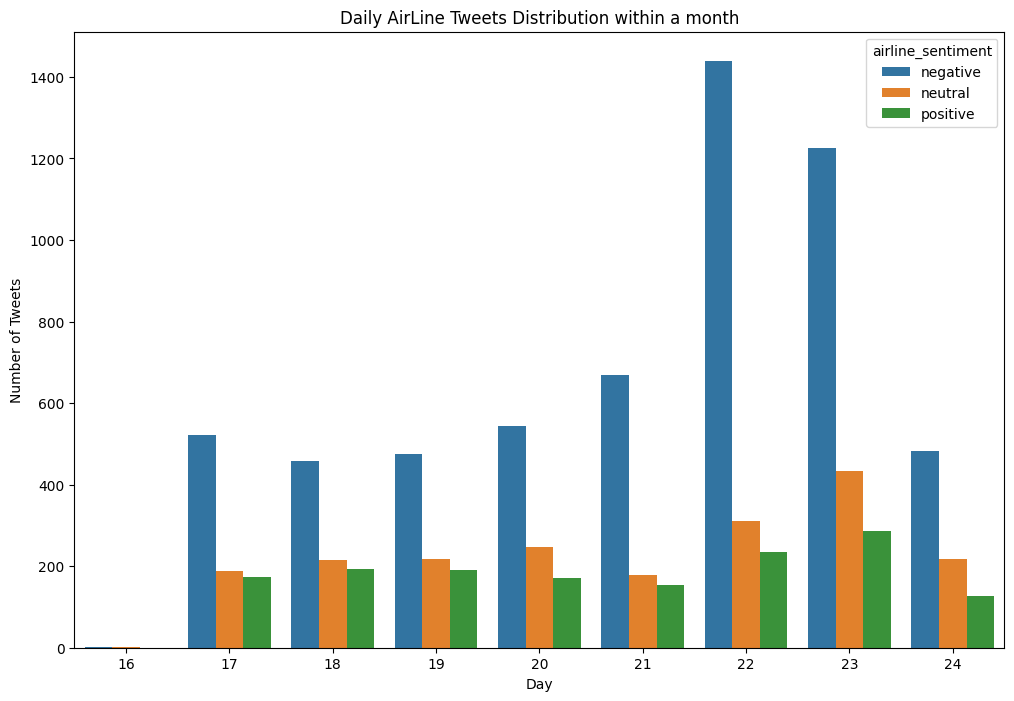

In [205]:
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x="day", hue="airline_sentiment", data=train_set)
ax.set_xlabel('Day')
ax.set_ylabel('Number of Tweets')
ax.set_title('Daily AirLine Tweets Distribution within a month')
del ax,fig,axes

<ipython-input-206-0222784239c7>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


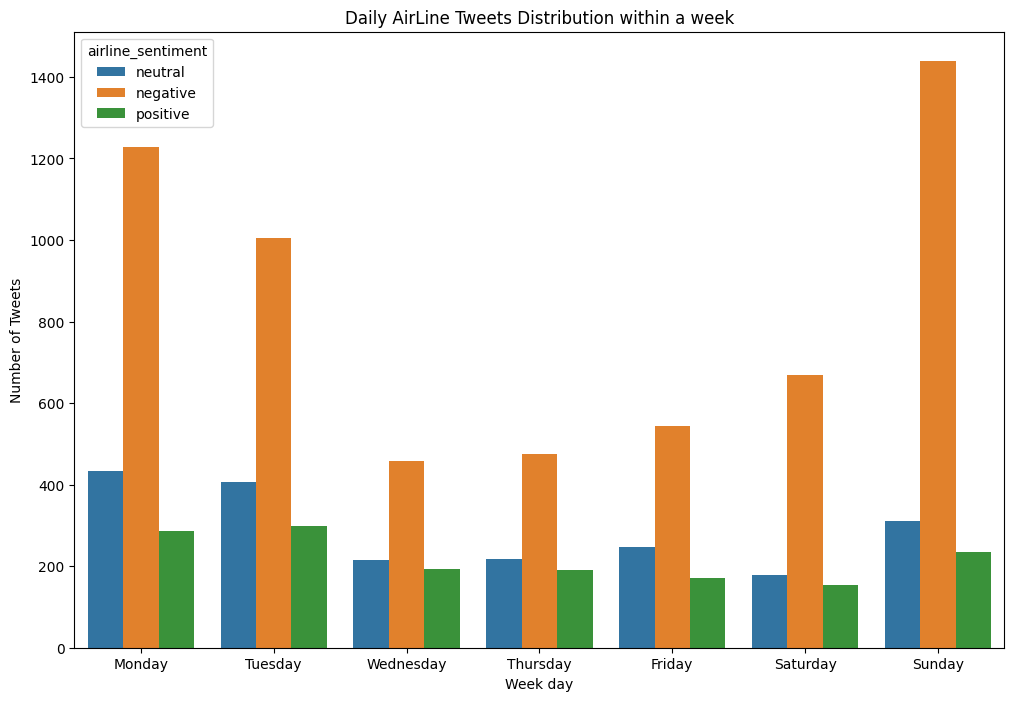

In [206]:
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x="week_day", hue="airline_sentiment", data=train_set)
ax.set_xlabel('Week day')
ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_ylabel('Number of Tweets')
ax.set_title('Daily AirLine Tweets Distribution within a week')
del ax,fig,axes

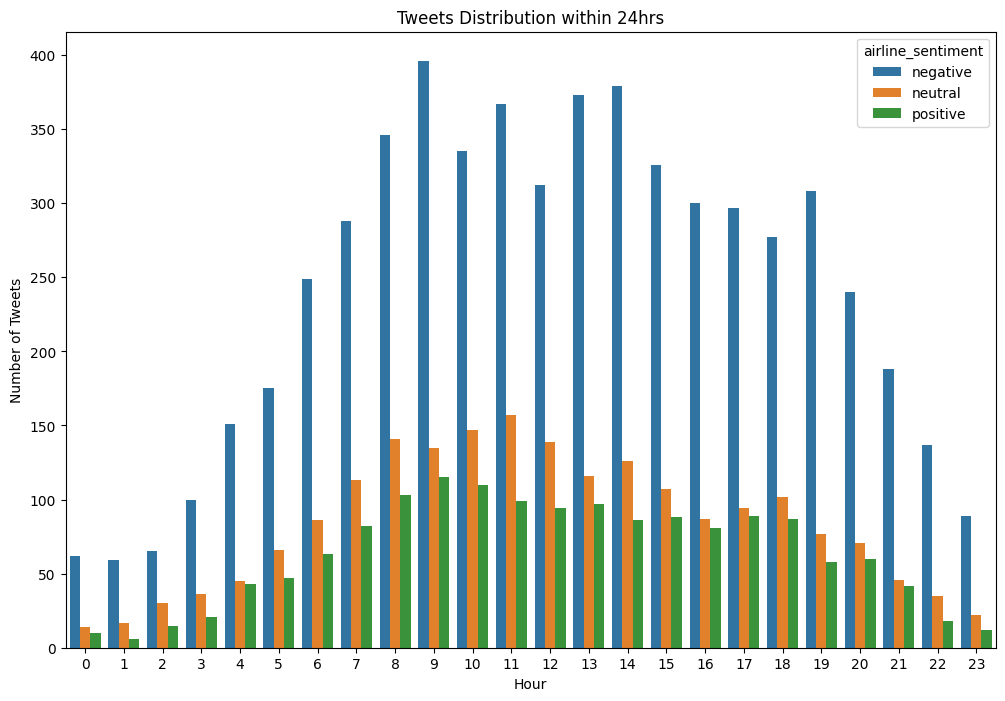

In [207]:
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x="hour", hue="airline_sentiment", data=train_set)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets Distribution within 24hrs')
del ax,fig,axes

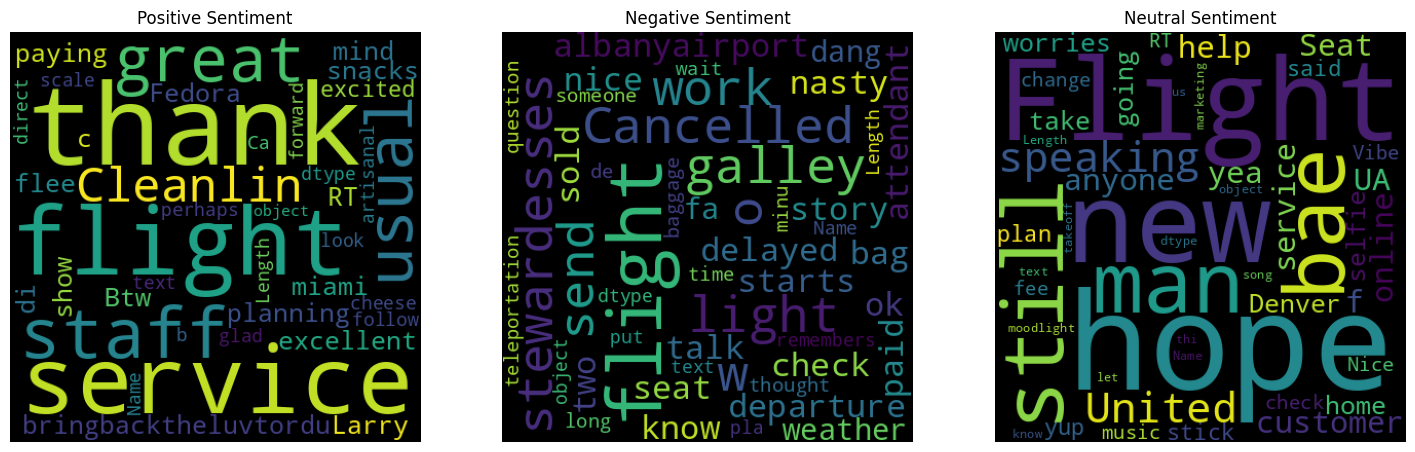

CPU times: user 1.52 s, sys: 238 ms, total: 1.76 s
Wall time: 1.71 s


In [208]:
%%time
# Create and generate a word
fig, ax = plt.subplots(1, 3, figsize=(18,18),edgecolor = 'k')
positive_tweet = WordCloud(width = 400,height = 400,background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(positive_text))
negative_tweet = WordCloud(width = 400,height = 400,background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(negative_text))
neutral_tweet = WordCloud(width = 400,height = 400,background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(neutral_text))
ax[0].imshow(positive_tweet)
ax[0].axis('off')
ax[0].set_title('Positive Sentiment')
ax[1].imshow(negative_tweet)
ax[1].axis('off')
ax[1].set_title('Negative Sentiment')
ax[2].imshow(neutral_tweet)
ax[2].axis('off')
ax[2].set_title('Neutral Sentiment')
plt.show()

### Implementation - Baseline Model

####Label encoding

*Encode sentiment  category (from 'neutral', 'positive', 'negative' to 0-1-2)*

In [263]:
le = LabelEncoder()
le.fit(train_set.airline_sentiment.tolist())
y_train = le.transform(train_set.airline_sentiment.tolist())
y_test = le.transform(test_set.airline_sentiment.to_list())
y_val = le.transform(val_set.airline_sentiment.to_list())

*One-Hot endcoding*

In [241]:
#enc = OneHotEncoder(sparse_output=False)
#enc.fit(y_train.reshape(-1,1))
#y_train = enc.transform(y_train.reshape(-1,1))
#y_test = enc.transform(y_test.reshape(-1,1))
#y_val = enc.transform(y_val.reshape(-1,1))

In [264]:
print("y_train shape:", y_train.shape)

y_train shape: (9354,)


In [234]:
train_set.airline_sentiment[:3]

,airline_sentiment
8183,negative
6870,neutral
14616,negative


In [277]:
print(y_train[0:3])

[0 1 0]


In [265]:
tfidf = TfidfVectorizer(max_df=0.95,min_df=2,ngram_range=(1,2)).fit(train_set['text'])

In [266]:
X = tfidf.transform(train_set['text'])

In [267]:
Xt = tfidf.transform(test_set['text'])

In [268]:
print("Vocabulary Size :", len(tfidf.vocabulary_))

Vocabulary Size : 10770


In [269]:
print(X.shape,Xt.shape)

(9354, 10770) (2928, 10770)


In [270]:
# feature selection
def features_selection(X_train, y_train, X_test):
	SKB = SelectKBest(score_func=chi2, k='all')
	SKB.fit(X_train, y_train)
	X_train_fs = SKB.transform(X_train)
	X_test_fs = SKB.transform(X_test)
	return X_train_fs, X_test_fs, SKB

In [271]:
X_train_fs, X_test_fs, fs = features_selection(X, y_train, Xt)

In [272]:
print(type(y_train))

<class 'numpy.ndarray'>


In [259]:
for i in range(3):
	print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.902589
Feature 1: 0.441442
Feature 2: 0.461666


In [273]:
param_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0]}
cross_val = StratifiedKFold(n_splits=5)
clf = LinearSVC(loss='hinge',random_state=101,tol=1e-5)

In [274]:
grids = GridSearchCV(clf, param_grid,cv=cross_val,refit=True,verbose=1,n_jobs=-1)
grids = grids.fit(X_train_fs, y_train)
print ("Best parameters: %s" % grids.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 1.0}


In [276]:
print("Baseline accuracy Score: %s" % grids.best_score_)

Baseline accuracy Score: 0.7759242819619466
